In [1]:
import os, glob, random, math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

random.seed(999)

# Paths
img_train_dir = f"../data/images/train"
img_val_dir   = f"../data/images/val"
label_train_dir = f"../data/labels/train"
label_val_dir = f"../data/labels/val"

images_train = sorted(glob.glob(f"{img_train_dir}/*.jpg", recursive=True))
images_test = sorted(glob.glob(f"{img_val_dir}/*.jpg", recursive = True))
labels_train = sorted(glob.glob(f"{label_train_dir}/*.txt", recursive=True))
labels_test = sorted(glob.glob(f"{label_val_dir}/*.txt", recursive = True))

print("# of training images:",len(images_train))
print("# of training labels:",len(labels_train))
print("# of testing images:",len(images_test))
print("# of testing labels:",len(labels_test))


# of training images: 18776
# of training labels: 18776
# of testing images: 7992
# of testing labels: 7992


In [2]:
#Check if there are any mismatched names
train_check, test_check = [], []

for i in range(len(images_train)):
    num1 = images_train[i].split('/')[-1].split('.')[0].split('_')[-1]
    num2 = labels_train[i].split('/')[-1].split('.')[0].split('_')[-1]
    train_check.append(num1 == num2)
if False in train_check:
    print("Stop. There are some mismatched names in training data")
else:
    print("Good to go(1/2)")

for i in range(len(images_test)):
    num1 = images_test[i].split('/')[-1].split('.')[0].split('_')[-1]
    num2 = labels_test[i].split('/')[-1].split('.')[0].split('_')[-1]
    test_check.append(num1 == num2)
if False in test_check:
    print("Stop. There are some mismatched names in training data")
else:
    print("Good to go(2/2)")
    
        

Good to go(1/2)
Good to go(2/2)


In [3]:
valid_numbers = random.sample(range(int(len(images_test))), int(len(images_test) / 2))
test_numbers = [i for i in range(len(images_test)) if i not in valid_numbers]

images_valid = sorted([images_test[i] for i in valid_numbers])
labels_valid = sorted([labels_test[i] for i in valid_numbers])

images_test = sorted([images_test[i] for i in test_numbers])
labels_test = sorted([labels_test[i] for i in test_numbers])

print(images_train)
print(labels_train)
print("\n")
print(images_valid)
print(labels_valid)
print("\n")
print(images_test)
print(labels_test)

['../data/images/train/IMG_00000001.jpg', '../data/images/train/IMG_00000006.jpg', '../data/images/train/IMG_00000007.jpg', '../data/images/train/IMG_00000008.jpg', '../data/images/train/IMG_00000010.jpg', '../data/images/train/IMG_00000011.jpg', '../data/images/train/IMG_00000012.jpg', '../data/images/train/IMG_00000013.jpg', '../data/images/train/IMG_00000014.jpg', '../data/images/train/IMG_00000015.jpg', '../data/images/train/IMG_00000016.jpg', '../data/images/train/IMG_00000019.jpg', '../data/images/train/IMG_00000020.jpg', '../data/images/train/IMG_00000022.jpg', '../data/images/train/IMG_00000025.jpg', '../data/images/train/IMG_00000026.jpg', '../data/images/train/IMG_00000027.jpg', '../data/images/train/IMG_00000028.jpg', '../data/images/train/IMG_00000029.jpg', '../data/images/train/IMG_00000030.jpg', '../data/images/train/IMG_00000031.jpg', '../data/images/train/IMG_00000032.jpg', '../data/images/train/IMG_00000033.jpg', '../data/images/train/IMG_00000035.jpg', '../data/images

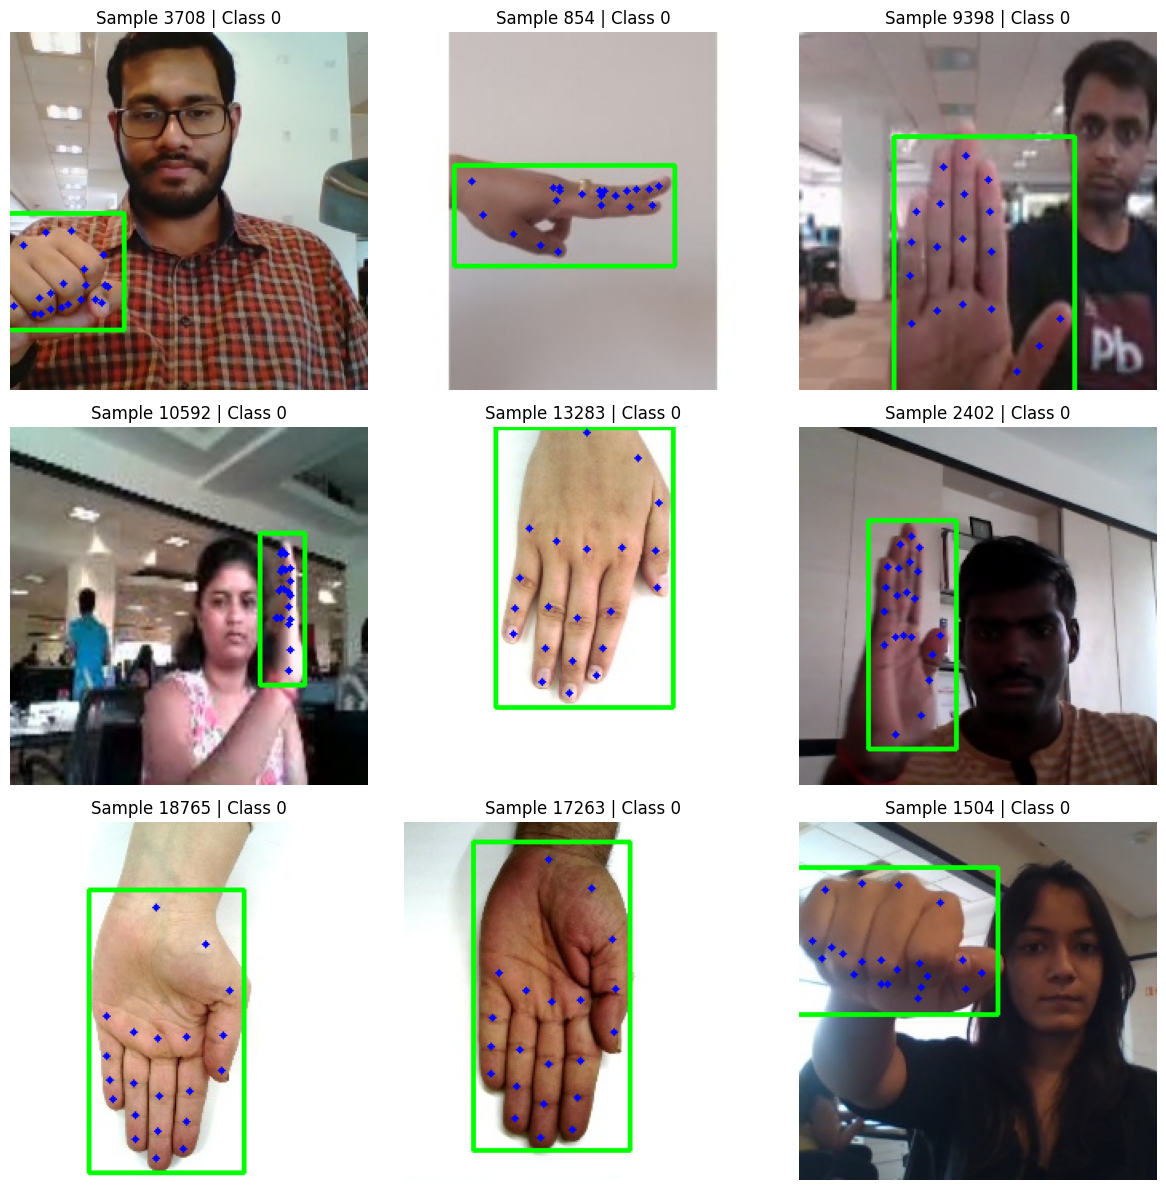

In [4]:
def draw_bbox(image_bgr, bbox_norm, img_w, img_h, color=(0, 255, 0)):
    cx, cy, bw, bh = bbox_norm
    x = int((cx - bw/2) * img_w)
    y = int((cy - bh/2) * img_h)
    w = int(bw * img_w)
    h = int(bh * img_h)
    out = image_bgr.copy()
    cv2.rectangle(out, (x, y), (x+w, y+h), color, 2)
    return out

def draw_keypoints(image_bgr, keypoints_norm, img_w, img_h, color=(255,0,0)):
    out = image_bgr.copy()
    keypoints = np.array(keypoints_norm).reshape(-1, 3)  # (21,3)

    for (x, y, v) in keypoints:
        if v > 0:
            px, py = int(round(x * img_w)), int(round(y * img_h))
            cv2.circle(out, (px, py), 2, color, -1)
    return out

# 3x3 subplot
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.ravel()

# random number
sample_indices = random.sample(range(len(labels_train)), 9)

for idx, sample_num in enumerate(sample_indices):
    with open(labels_train[sample_num], "r", encoding="utf-8") as f:
        text = f.read()

    text_list = list(map(float, text.split()))
    obj_class = int(text_list[0])
    bbox = text_list[1:5]
    key_points = text_list[5:]

    # Ream images
    image = cv2.imread(images_train[sample_num])
    H, W = image.shape[:2]

    vis = draw_bbox(image, bbox, W, H)
    vis = draw_keypoints(vis, key_points, W, H)

    # subplot
    axes[idx].imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    axes[idx].set_title(f"Sample {sample_num} | Class {obj_class}")
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class HandDataset(Dataset):
    def __init__(self, images_list, labels_list, transform=transforms.ToTensor()):
        self.images_list = images_list
        self.labels_list = labels_list
        self.transform = transform
        
    def __len__(self):
        return len(self.images_list)
    
    def __getitem__(self, idx):
        img_path = self.images_list[idx]
        label_path = self.labels_list[idx]
        
        image = Image.open(img_path).convert("RGB")
        W, H = image.size
        image = self.transform(image)
        
        with open(label_path, "r", encoding="utf-8") as f:
            text = f.read()
            
        vals = list(map(float, text.split()))
        
        #bbox
        cx, cy, bw, bh = vals[1:5] #cx,cy: box center | bw,bh: box w,h
        x1 = (cx - bw/2) * W
        y1 = (cy - bh/2) * H
        x2 = (cx + bw/2) * W
        y2 = (cy + bh/2) * H
        boxes = torch.tensor([[x1, y1, x2, y2]], dtype = torch.float32)
        labels = torch.tensor([1], dtype=torch.int64)
        
        #keypoints
        kpts = vals[5:]
        kpts = np.array(kpts).reshape(-1,3)
        kpts[:,0] *= W
        kpts[:,1] *= H
        keypoints = torch.tensor(kpts, dtype=torch.float32).unsqueeze(0) # (N, K=21, 3)
        
        target = {"boxes": boxes,
                  "labels": labels,
                  "keypoints": keypoints}
        
        return image, target
    
def collate_fn(batch): #torchvision detection model expects list format
    images, targets = list(zip(*batch))   # unzip
    return list(images), list(targets)



In [6]:
from torch.utils.data import DataLoader

train_dataset = HandDataset(images_train, labels_train)
valid_dataset = HandDataset(images_valid, labels_valid)
test_dataset = HandDataset(images_test, labels_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)


In [7]:
print(len(train_loader))

294


In [8]:
for images, targets in train_loader:
    print(len(images))        # 4
    print(targets[0].keys())  # dict: 'boxes', 'labels'
    print(targets[0]["boxes"])
    break

64
dict_keys(['boxes', 'labels', 'keypoints'])
tensor([[  2.,   8., 118., 184.]])


In [9]:
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_320_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("device: ", DEVICE)

def build_hand_detector():
    model = fasterrcnn_mobilenet_v3_large_320_fpn(weights="DEFAULT")
    in_feats = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_feats, 2)
    return model.to(DEVICE)

model = build_hand_detector()

device:  cuda


In [10]:
print("CUDA available:", torch.cuda.is_available())
print("Device being used:", DEVICE)
if DEVICE == "cuda":
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("Current CUDA device index:", torch.cuda.current_device())

CUDA available: True
Device being used: cuda
GPU Name: NVIDIA RTX A4000
Current CUDA device index: 0


In [11]:
import torch.optim as optim

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

EPOCHS = 5
for epoch in range(1, EPOCHS+1):
    model.train()
    running = 0.0
    for step, (images, targets) in enumerate(train_loader, 1):
        images  = [img.to(DEVICE) for img in images]
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running += loss.item()
        if step % 20 == 0:
            print(f"[Ep {epoch}: St {step} / {len(train_loader)}] total={loss.item():.4f} "
                  + " ".join([f"{k}={v.item():.3f}" for k,v in loss_dict.items()]))
                                                                         
    print(f"Epoch {epoch} train loss avg: {running/max(1,step):.4f}")


[Ep 1: St 20 / 294] total=1.0534 loss_classifier=0.317 loss_box_reg=0.730 loss_objectness=0.006 loss_rpn_box_reg=0.001
[Ep 1: St 40 / 294] total=1.1248 loss_classifier=0.341 loss_box_reg=0.778 loss_objectness=0.004 loss_rpn_box_reg=0.002
[Ep 1: St 60 / 294] total=0.8067 loss_classifier=0.227 loss_box_reg=0.577 loss_objectness=0.002 loss_rpn_box_reg=0.001
[Ep 1: St 80 / 294] total=0.8358 loss_classifier=0.217 loss_box_reg=0.614 loss_objectness=0.003 loss_rpn_box_reg=0.001
[Ep 1: St 100 / 294] total=0.8780 loss_classifier=0.267 loss_box_reg=0.607 loss_objectness=0.003 loss_rpn_box_reg=0.001
[Ep 1: St 120 / 294] total=0.7238 loss_classifier=0.231 loss_box_reg=0.488 loss_objectness=0.003 loss_rpn_box_reg=0.001
[Ep 1: St 140 / 294] total=0.7510 loss_classifier=0.152 loss_box_reg=0.597 loss_objectness=0.001 loss_rpn_box_reg=0.001
[Ep 1: St 160 / 294] total=0.7798 loss_classifier=0.228 loss_box_reg=0.549 loss_objectness=0.002 loss_rpn_box_reg=0.001
[Ep 1: St 180 / 294] total=0.7688 loss_class

In [12]:
import torch
from torchvision.ops import box_iou

@torch.no_grad()
def test_accuracy(model, data_loader, device, score_thresh=0.5, iou_thresh=0.5):
    """
    Returns:
        metrics = {
            'precision': ...,
            'recall': ...,
            'f1': ...,
            'image_accuracy': ...,
            'tp': ..., 'fp': ..., 'fn': ...
        }
    """
    model.eval()
    TP = FP = FN = 0
    img_correct = 0
    n_images = 0

    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)  # list of dicts

        for out, tgt in zip(outputs, targets):
            n_images += 1

            # GT
            gt_boxes  = tgt["boxes"].to("cpu")
            gt_labels = tgt["labels"].to("cpu")

            # Pred
            pred_boxes  = out["boxes"].to("cpu")
            pred_scores = out["scores"].to("cpu")
            pred_labels = out["labels"].to("cpu")

            # 스코어 threshold로 필터
            keep = pred_scores >= score_thresh
            pred_boxes  = pred_boxes[keep]
            pred_labels = pred_labels[keep]

            # 클래스별 매칭(정확 매칭: 라벨 동일 + IoU>=threshold)
            # -> 그리디 매칭 (예측 기준으로 한 번씩 GT에 할당)
            matched_gt = set()
            tp_img = fp_img = 0

            if len(pred_boxes) > 0 and len(gt_boxes) > 0:
                # 동일 클래스끼리만 IoU 계산을 효율적으로 하기 위해 라벨로 그룹핑
                for cls in torch.unique(torch.cat([gt_labels, pred_labels], dim=0)):
                    # 이 클래스에 속한 GT/Pred만 취함
                    gt_idx = (gt_labels == cls).nonzero(as_tuple=True)[0]
                    pr_idx = (pred_labels == cls).nonzero(as_tuple=True)[0]
                    if len(gt_idx) == 0 and len(pr_idx) == 0:
                        continue
                    if len(pr_idx) == 0:
                        continue

                    ious = box_iou(pred_boxes[pr_idx], gt_boxes[gt_idx]).numpy()
                    # 예측 하나씩 그리디 매칭
                    for pi in range(len(pr_idx)):
                        if ious.shape[1] == 0:
                            # 이 클래스에 GT가 없으면 전부 FP
                            fp_img += 1
                            continue
                        gi = ious[pi].argmax()
                        gt_global_index = gt_idx[gi].item()
                        if ious[pi, gi] >= iou_thresh and gt_global_index not in matched_gt:
                            tp_img += 1
                            matched_gt.add(gt_global_index)
                        else:
                            fp_img += 1
            else:
                # GT 없고 Pred만 있으면 전부 FP, Pred 없고 GT만 있으면 전부 FN
                if len(pred_boxes) > 0 and len(gt_boxes) == 0:
                    fp_img += len(pred_boxes)

            fn_img = len(gt_boxes) - len(matched_gt)

            # 누적
            TP += tp_img
            FP += fp_img
            FN += fn_img

            # 이미지 단위 정확도: GT 모두 매칭되고 남는 예측(=FP)이 없으면 정답
            if fn_img == 0 and fp_img == 0:
                img_correct += 1

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1        = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0
    image_acc = img_correct / n_images if n_images > 0 else 0.0

    metrics = {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "image_accuracy": image_acc,
        "tp": TP, "fp": FP, "fn": FN
    }
    print(f"[TEST] P={precision:.4f} R={recall:.4f} F1={f1:.4f} ImgAcc={image_acc:.4f} (TP:{TP} FP:{FP} FN:{FN})")
    return metrics


In [13]:
metrics = test_accuracy(model, test_loader, DEVICE, score_thresh=0.5, iou_thresh=0.5)


[TEST] P=0.9791 R=0.9870 F1=0.9831 ImgAcc=0.9772 (TP:3944 FP:84 FN:52)


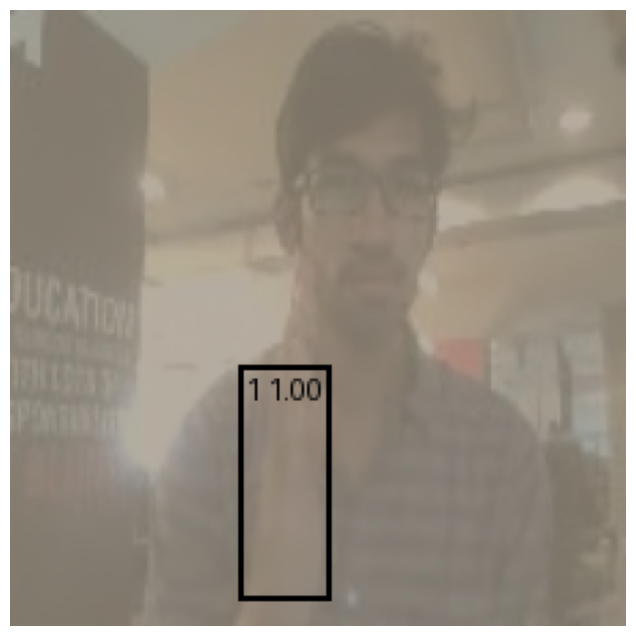

In [19]:
import torch
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

# (옵션) 이미지가 Normalize되어 있다면 원복 함수 정의
# 예: transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
IM_MEAN = [0.485, 0.456, 0.406]
IM_STD  = [0.229, 0.224, 0.225]

def denormalize(img_tensor, mean=IM_MEAN, std=IM_STD):
    """
    img_tensor: (C,H,W), float, Normalize된 값
    return: (C,H,W), float in [0,1]
    """
    # img * std + mean
    mean = torch.tensor(mean, device=img_tensor.device)[:, None, None]
    std  = torch.tensor(std,  device=img_tensor.device)[:, None, None]
    img = img_tensor * std + mean
    return img.clamp(0, 1)

@torch.no_grad()
def visualize_one_from_loader(model, data_loader, device, score_thresh=0.5, category_names=None, save_path=None):
    """
    category_names: {class_id:int -> name:str} 딕셔너리(옵션). 없으면 정수 라벨 그대로 표시
    save_path: 파일로 저장 경로(옵션). None이면 화면에만 표시
    """
    model.eval()

    # 1) 배치에서 한 장 꺼내기
    images, targets = next(iter(data_loader))   # images: list[Tensor(C,H,W)]
    img = images[0].to(device)
    # targets가 있을 경우: targets[0]["boxes"], ["labels"]로 GT도 접근 가능

    # 2) 추론
    outputs = model([img])
    output = outputs[0]
    boxes  = output["boxes"].detach().cpu()
    scores = output["scores"].detach().cpu()
    labels = output["labels"].detach().cpu()

    # 3) score threshold로 필터링
    keep = scores >= score_thresh
    boxes  = boxes[keep]
    labels = labels[keep]
    scores = scores[keep]

    # 4) 시각화용 이미지 준비
    #   - 모델 입력이 Normalize되어 있다면 되돌리고
    #   - uint8 [0,255], 3xHxW 로 변환
    img_vis = img.detach().cpu()
    if img_vis.dtype != torch.uint8:
        # Normalize 되어 있다고 가정 → 복원
        img_vis = denormalize(img_vis)
        # 그레이스케일이면 3채널로
        if img_vis.ndim == 3 and img_vis.shape[0] == 1:
            img_vis = img_vis.repeat(3, 1, 1)
        # [0,1] → [0,255] uint8
        img_vis = (img_vis * 255).clamp(0,255).to(torch.uint8)

    # 5) 라벨 텍스트 만들기 (ex: "person 0.91")
    if category_names is not None:
        texts = [f"{category_names.get(int(c), int(c))} {s:.2f}" for c,s in zip(labels, scores)]
    else:
        texts = [f"{int(c)} {s:.2f}" for c,s in zip(labels, scores)]

    # 6) bbox 그리기
    if len(boxes) > 0:
        drawn = draw_bounding_boxes(
            image=img_vis,
            boxes=boxes,
            labels=texts,
            width=2
        )
    else:
        drawn = img_vis  # 감지 없음

    # 7) 표시/저장
    pil_img = F.to_pil_image(drawn)
    if save_path:
        pil_img.save(save_path)
        print(f"Saved: {save_path}")

    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.imshow(pil_img)
    plt.show()

# 사용 예시:
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(DEVICE)
# class_names = {1:"person", 2:"car", 3:"cat"}  # 있는 경우만
visualize_one_from_loader(model, test_loader, DEVICE, score_thresh=0.5, category_names=None, save_path=None)


In [21]:
torch.save(model.state_dict(), "../model_test/model_0826.pth")